From: https://w.wiki/6Ww7 

Wikidata link: [http://www.wikidata.org/entity/Q17276254](http://www.wikidata.org/entity/Q17276254)

Title: Flowers in a Glass Flask

Year: 1612

Creator: Jacob de Gheyn II

Copyright: public domain



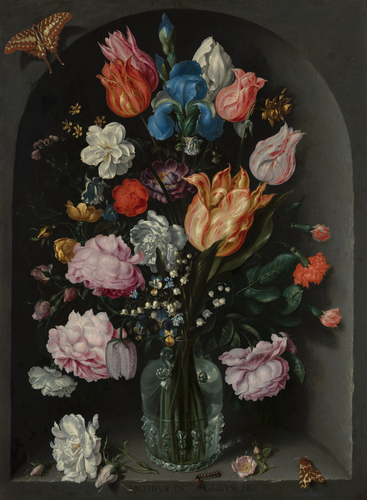




Wikidata link: [http://www.wikidata.org/entity/Q17737853](http://www.wikidata.org/entity/Q17737853)

Title: Portrait of Jan Pietersz. Sweelinck (1562-1621)

Year: 1606

Creator: Gerrit Pietersz Sweelink

Copyright: public domain



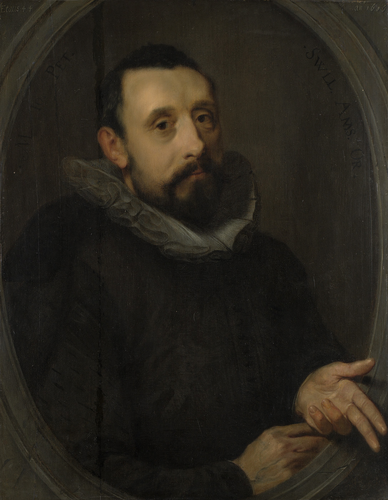




Wikidata link: [http://www.wikidata.org/entity/Q24451307](http://www.wikidata.org/entity/Q24451307)

Title: Willem van den Kerckhoven and his Family

Year: 1652

Creator: Johannes Mytens

Copyright: public domain



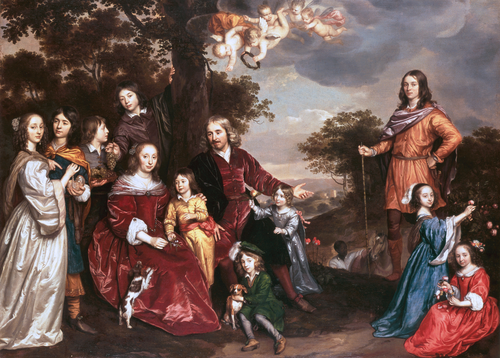




Wikidata link: [http://www.wikidata.org/entity/Q27538256](http://www.wikidata.org/entity/Q27538256)

Title: Still-life with Carp

Year: 1647

Creator: Abraham van Beijeren

Copyright: public domain



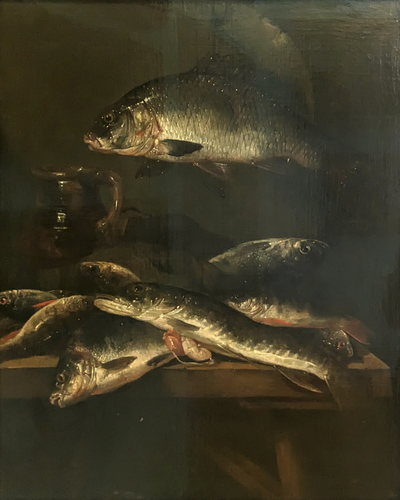




Wikidata link: [http://www.wikidata.org/entity/Q28060097](http://www.wikidata.org/entity/Q28060097)

Title: Q28060097

Year: 1642

Creator: Lucas Franchoys the Younger

Copyright: public domain



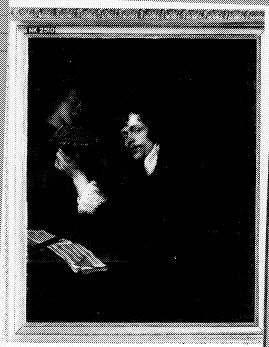




Wikidata link: [http://www.wikidata.org/entity/Q28060433](http://www.wikidata.org/entity/Q28060433)

Title: musical party

Year: 1657

Creator: Gerbrand van den Eeckhout

Copyright: public domain



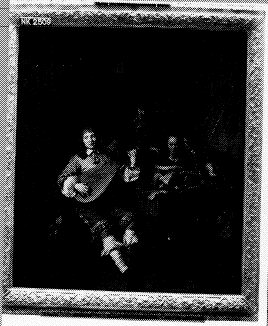




Wikidata link: [http://www.wikidata.org/entity/Q28060433](http://www.wikidata.org/entity/Q28060433)

Title: musical party

Year: 1657

Creator: Gerbrand van den Eeckhout

Copyright: public domain



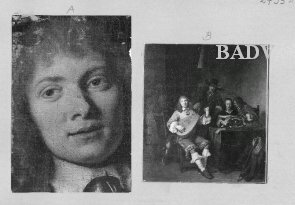




Wikidata link: [http://www.wikidata.org/entity/Q28061670](http://www.wikidata.org/entity/Q28061670)

Title: Arcadian landscape

Year: 1615

Creator: Moses van Uyttenbroeck

Copyright: public domain



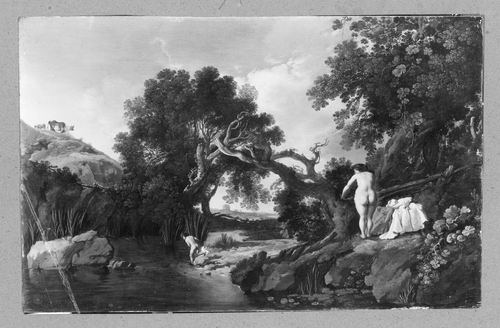




Wikidata link: [http://www.wikidata.org/entity/Q28094197](http://www.wikidata.org/entity/Q28094197)

Title: Portrait of dr. Nicolaes Cromhout (1561-1641)

Year: 1622

Creator: http://www.wikidata.org/.well-known/genid/fe3ac095438ca74a6fe6f49001bc25bd

Copyright: public domain



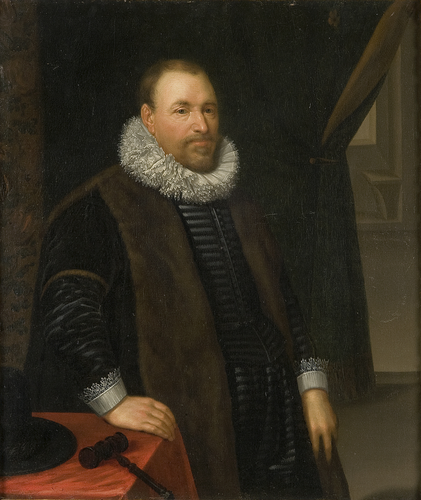

In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

from PIL import Image
import requests

endpoint_url = "https://query.wikidata.org/sparql"

query = """#defaultView:ImageGrid
SELECT ?item ?itemLabel ?inceptionyear ?creator ?creatorLabel ?copyright ?copyrightLabel ?image
WHERE
{
  # find items which:
  # are instances of (wdt:P31) paintings (wd:Q3305213)
  # have the property (wdt:P195) of being in collection wd:Q1499958 (Kunstmuseum Den Haag https://www.wikidata.org/wiki/Wikidata:WikiProject_sum_of_all_paintings/Collection/Kunstmuseum_Den_Haag)
  ?item wdt:P31 wd:Q3305213 .
  ?item wdt:P195 wd:Q1499958 .
  # get the item's creator property (wdt:P170)
  ?item wdt:P170 ?creator .
  # get the item's image property (wdt:P18)
  ?item wdt:P18 ?image .
  # get the item's copyright status (wdt:P6216)
  ?item wdt:P6216 ?copyright . 
  {
    ?item wdt:P571 ?inception.
    BIND(YEAR(?inception) AS ?inceptionyear)
  }

  # filter out all paintings not created between the years 1600 and 1700
  FILTER((1600  <= ?inceptionyear) && (?inceptionyear < 1700 ))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". } }
# limit to nine results
LIMIT 9"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# MAIN PROGRAM

results = get_results(endpoint_url, query)

for result in results['results']['bindings']:
    print('Wikidata link: ' + '[' + result['item']['value'] + ']' + '(' + result['item']['value'] + ')' + '\n')
    print('Title: ' + result['itemLabel']['value'] + '\n')
    print('Year: ' + result['inceptionyear']['value'] + '\n')
    print('Creator: ' + result['creatorLabel']['value'] + '\n')
    print('Copyright: ' + result['copyrightLabel']['value'] + '\n')

    # get image from image URL and display resized version
    image_url=result['image']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    print('\n\n')
